In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import io
from PIL import Image
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time
from sklearn.svm import SVC

In [2]:
# FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN
def seed_everything(seed=4):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(4)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
FRAME_OUTPUT_DIRECTORY = "/home2/jxrs34/final_year_project/output_resized_28_rgb_frames"

# 1.0 Visual

### DataLoader

In [5]:
face_test = pd.read_pickle("face_test.pkl")

## 1.1 Example where the model succeeded

#### 1087_TSI_NEU_XX

<video width="320" height="320" 
       src="./videos/1087_TSI_NEU_XX.mp4"  
       type="video/flv"
       controls>
</video>

##### Note: The individual frames were extracted using the OPENFACE toolkit before the following steps

In [7]:
class OpenFaceFramesDataset(Dataset):
    def __init__(self, dataset, root_dir=FRAME_OUTPUT_DIRECTORY, transform=None):
        """
        Args:
            dataset_path (string): Path to the dataset with file names and emotion.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.root_dir = root_dir
        self.transform = transform
        self.NUM_FRAMES = 75

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = {'frames': [], 'labels': []}
        folder_path = os.path.join(self.root_dir, self.dataset.iloc[idx, 0] + "_aligned")
        # sanity check to make sure its a directory
        if os.path.isdir(folder_path):
            frames = []
            file_list = [files for files in os.listdir(folder_path)]
            equal_frame_file_list = file_list

            # convert the files list to a dictionary
            filelist_dict = { ind: name for (ind,name) in enumerate(file_list) }
            if len(file_list) < self.NUM_FRAMES:
                # duplicate last frame
                last_duplicated = [file_list[-1]] * (self.NUM_FRAMES-len(file_list))
                equal_frame_file_list = file_list + last_duplicated
            elif len(file_list) > self.NUM_FRAMES:
                increment = len(file_list)//self.NUM_FRAMES
                # Get indexes of frames that are equally spaced
                frame_indexes = [increment*n for n in range(self.NUM_FRAMES)]
                equal_frame_file_list = [filelist_dict[index] for index in frame_indexes]
            
            for image_file in equal_frame_file_list:
                image = Image.open(folder_path + "/" + image_file)
                # channels x height x width
                image_tensor = self.transform(image) if self.transform else torchvision.transforms.ToTensor()(image)
                frames.append(image_tensor)
            frames_tensor = torch.stack(frames)
            sample = {'frames': frames_tensor, 'labels': self.dataset.iloc[idx, 1]}
        return sample

In [8]:
BATCH_SIZE = 1 # for demo purposes


TEST_TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                           ])
test_dataset = OpenFaceFramesDataset(dataset=face_test,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=TEST_TRANSFORMATIONS)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=True)

In [9]:
labelencoder = pd.read_pickle("label_encoder.pkl")

emotion shown: ['N']


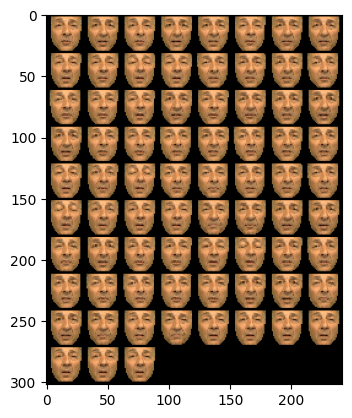

In [10]:
random_sample = next(iter(test_loader))
random_sample_frames = random_sample['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([random_sample["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_sample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [11]:
TEST_NORM_TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                [0.5327, 0.3879, 0.2578],
                                                [0.3316, 0.2488, 0.1824]
                                            )
                                           ])
test_norm_dataset = OpenFaceFramesDataset(dataset=face_test,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=TEST_NORM_TRANSFORMATIONS)
test_norm_loader = DataLoader(
    test_norm_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # for demo purposes
    num_workers=0,
    drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


emotion shown: ['N']


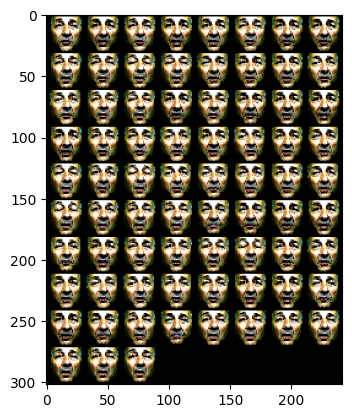

In [12]:
random_sample = next(iter(test_norm_loader))
random_sample_frames = random_sample['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([random_sample["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_sample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

### Model

In [13]:
DROPOUT_PROB_1 = 0.07

class sixLayerCNNLSTM(nn.Module):
    def __init__(self):
        super(sixLayerCNNLSTM, self).__init__()

        self.cnn_layers = nn.Sequential(
                self.conv_block(in_channels=3, out_channels=32), # [4, 32, 73, 26, 26]
                self.conv_block(in_channels=32, out_channels=64), # [4, 64, 71, 24, 24]
                nn.MaxPool3d((2,2,2)), # [4, 64, 35, 12, 12]
                self.conv_block(in_channels=64, out_channels=128), # [4, 128, 33, 10, 10]
        )

        self.lstm = nn.LSTM(
                    input_size=12800,
                    hidden_size=64,
                    num_layers=1,
                    dropout=0.14,
                    # batch_first=True # expect (batch, timestamps, input_features) instead of default (timesteps, batch, input_features)
        )
        self.output_layer = nn.Sequential(
                nn.Linear(in_features=64, out_features=32),
                nn.LeakyReLU(negative_slope=0.1, inplace=False),
                nn.Dropout(p=0.21),

                nn.Linear(in_features=32, out_features=6),
            )
    def conv_block(self, in_channels=64, out_channels=2):
        return nn.Sequential(
                # required shape (N, channels(3), frames, h, w)
                nn.Conv3d(in_channels, out_channels, kernel_size=(3,3,3)),
                nn.LeakyReLU(negative_slope=0.1, inplace=False),
                nn.BatchNorm3d(out_channels),
                nn.Dropout3d(p=0.07),
        )
    
    def forward(self, x):
        x = torch.permute(x, (0,2,1,3,4)) #torch.Size([4, 3, 75, 28, 28]) 
        # input to conv3d = N, C_in, D (num frames), H, W
        # output has same format
        cnn_output = self.cnn_layers(x)

        # input to LSTM = (L (sequence len), N (batch_size), input size) when batch_first=False
        # 33 is D i.e. the temporal information so will be equal to L the timesteps
        lstm_output, (hidden_n, cell_n) = self.lstm(cnn_output.view(33, BATCH_SIZE, -1))

        output = self.output_layer(lstm_output[-1,:,:])
        return output

In [14]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
    From https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [59]:
path = "./best_model/lr_1e-05_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_model_125.chkpt"
net = sixLayerCNNLSTM().to(device)

def index_loader(loader, n):
    iterable = iter(loader)
    for i in range(n):
        curr_data = next(iterable)
    return curr_data
        
def demo_prediction(model, path, test_loader, i=0): 
    model.apply(reset_weights)
    # FROM https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model
    model.load_state_dict(torch.load(path)["model"]) 
    total = 0 
    model.eval()
    # Initialize the prediction and label lists(tensors)
    pred_arr=torch.zeros(0,dtype=torch.long, device='cpu')
    label_arr=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad(): 
        data = index_loader(test_loader, i)#next(iter(test_loader))
        inputs, labels = data['frames'], data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        start = time.time()
        predicted_outputs = model(inputs) 
        _, predicted = torch.max(predicted_outputs, 1) 
        end = time.time()
        print(f'Time taken to predict: {end - start}')

        # Append batch prediction results
        # inspired by https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
        pred_arr=torch.cat([pred_arr, predicted.view(-1).cpu()])
        label_arr=torch.cat([label_arr, labels.view(-1).cpu()])
        
        return label_arr, pred_arr

In [ ]:
label_arr, pred_arr = demo_prediction(net, path, test_norm_loader, 0)

In [34]:
print(f'emotion shown: {labelencoder.inverse_transform([label_arr.item()])}')
print(f'emotion predicted: {labelencoder.inverse_transform([pred_arr.item()])}')

emotion shown: ['N']
emotion predicted: ['N']


## 1.2 Example where the model failed

### 1036_DFA_FEA_XX

<video width="320" height="320" 
       src="./videos/1036_DFA_FEA_XX.mp4"  
       type="video/flv"
       controls>
</video>

emotion shown: ['F']


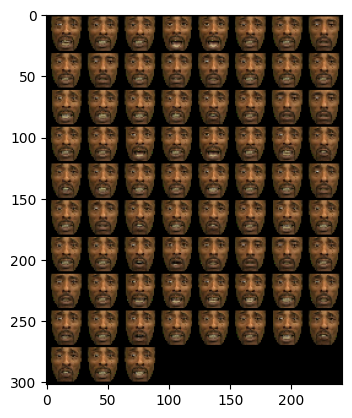

In [62]:
badsample_data = index_loader(test_loader, 7)
random_badsample_frames = badsample_data['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([badsample_data["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_badsample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


emotion shown: ['F']


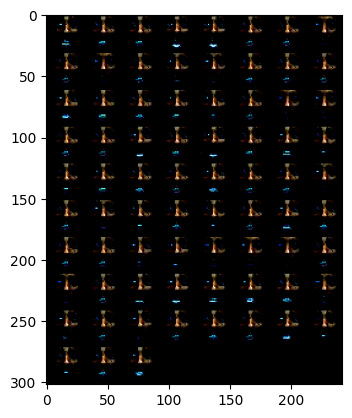

In [63]:
badsample_data = index_loader(test_norm_loader, 7)
random_badsample_frames = badsample_data['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([badsample_data["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_badsample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [66]:
label_arr_badsample, pred_arr_badsample = demo_prediction(net, path, test_norm_loader, 7)
print(f'emotion shown: {labelencoder.inverse_transform([label_arr_badsample.item()])}')
print(f'emotion predicted: {labelencoder.inverse_transform([pred_arr_badsample.item()])}')

Reset trainable parameters of layer = Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=6, bias=True)
Reset trainable parameters of layer = LSTM(12800, 64, dropout=0.14)
Time taken to predict: 0.002031087875366211
emotion shown: ['F']
emotion predicted: ['S']


##### It should be noted that this clip contained features commonly associated w/ sadness such as slanted eyebrows (this may not be the scientific term)

# 2.0 Audio

In [18]:
standardised_voice_train_os = pd.read_pickle("./audio_tables/voice_train_os_clean_stand_df")

y_train = standardised_voice_train_os.intendedEmo
X_train = standardised_voice_train_os.drop(columns=["intendedEmo"])

pca = PCA(n_components=0.99, random_state=4)
pca.fit(X_train)
pca_data = pca.transform(X_train)
pca_data.shape

(2479, 1740)

In [19]:
standardised_voice_test_os = pd.read_pickle("./audio_tables/voice_test_os_clean_stand_df")

## 2.1 Example where the model succeeded

In [20]:
standardised_voice_test_os_sample = pd.DataFrame(standardised_voice_test_os.iloc[2]).T
standardised_voice_test_os_sample

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,intendedEmo
1005_TSI_FEA_XX.wav,0.072821,1.090732,1.357131,-0.330618,-0.743743,0.236512,-0.758637,0.894522,0.287812,-0.057435,...,1.401755,0.437041,0.473532,-1.020072,-2.346261,0.833904,-0.046743,0.548417,-0.461274,2.0


### 1005_TSI_FEA_XX.wav - "The surface is slick"

<audio width="320" height="240"
       src="./CREMA-D/AudioWAV/1005_TSI_FEA_XX.wav"  
       controls>
</audio>

In [21]:
y_test_match_sample = standardised_voice_test_os_sample.intendedEmo
X_test_match_sample = standardised_voice_test_os_sample.drop(columns=["intendedEmo"])

In [22]:
best_svm_clean_pca = SVC(C=100, gamma=0.0001, random_state=4, kernel="rbf").fit(pca_data, y_train)
pca_test_match = pca.transform(X_test_match_sample)
y_pred_match = best_svm_clean_pca.predict(pca_test_match)

In [23]:
print(f'emotion predicted: {labelencoder.inverse_transform([y_pred_match[0]])}')
print(f'emotion shown: {labelencoder.inverse_transform([int(y_test_match_sample[0])])}')

emotion predicted: ['F']
emotion shown: ['F']


## 2.2 Example where the model failed

In [24]:
standardised_voice_test_os_badsample = pd.DataFrame(standardised_voice_test_os.iloc[0]).T
standardised_voice_test_os_badsample

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,intendedEmo
1007_TIE_ANG_XX.wav,-0.18907,2.418781,-0.641811,-0.223874,-0.610963,-0.713353,-0.637337,-0.687644,-0.720181,-0.06771,...,-0.478409,-0.678624,-0.701539,1.030011,0.960879,-0.701591,-0.626078,-0.004539,-0.708759,0.0


### 1007_TIE_ANG_XX.wav	 - "That is exactly what happened"

<audio width="320" height="240"
       src="./CREMA-D/AudioWAV/1007_TIE_ANG_XX.wav"  
       controls>
</audio>

In [25]:
y_test_match_badsample = standardised_voice_test_os_badsample.intendedEmo
X_test_match_badsample = standardised_voice_test_os_badsample.drop(columns=["intendedEmo"])

pca_test_match_badsample = pca.transform(X_test_match_badsample)

In [26]:
pca_test_match_badsample = pca.transform(X_test_match_badsample)
y_pred_match_badsample = best_svm_clean_pca.predict(pca_test_match_badsample)
print(f'emotion predicted: {labelencoder.inverse_transform([y_pred_match_badsample[0]])}')
print(f'emotion shown: {labelencoder.inverse_transform([int(y_test_match_badsample[0])])}')

emotion predicted: ['D']
emotion shown: ['A']
